In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.layers import Embedding, LSTM, Dropout, Dense, GRU, SimpleRNN, Flatten

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [2]:
df = pd.read_csv('../data/train.csv')

In [3]:
texts = df['text'].astype(str)
relevance = df['positive']
X_train, X_test, y_train, y_test = train_test_split(texts, relevance, test_size=0.15, random_state=42, shuffle=True)

In [4]:
max_words = 5000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [5]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [6]:
# Padding
maxlen = 100 
X_train = pad_sequences(sequences_train, maxlen=maxlen)
y_train = np.array(y_train)

X_test = pad_sequences(sequences_test, maxlen=maxlen)
y_test = np.array(y_test)


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Создадим функцию для тестирования моделей

In [9]:
def create_plot(history):
    plt.plot(
        history.history['loss'],
        label='Train loss'
        )
    plt.plot(
        history.history['val_loss'], 
        label='Val loss'
        )
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(1, 11))
    plt.legend()
    plt.show()

def calculate_metrics(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('Test accuracy is {}'.format(accuracy))
    print('Test precision is {}'.format(precision))
    print('Test recall is {}'.format(recall))
    print('Test f1 is {}'.format(f1))


def compile_fit_model(model, X_train, y_train, X_val, y_val):
    model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy']
        )
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping],
        validation_data=(X_val, y_val),
        shuffle=False
        )
    return history

def test_model(model, X_train, y_train, X_test, y_test, X_val, y_val, threshold=0.5):
    """Trains and tests a given model.

    Args:
        model: The model to be trained and tested.
        X_train: Training features.
        y_train: Training labels.
        X_test: Test features.
        y_test: Test labels.
        X_val: Validation features.
        y_val: Validation labels.
        threshold: Threshold for converting probabilities to binary predictions.

    Returns:
        None
    """
        
    history = compile_fit_model(model, X_train, y_train, X_val, y_val)
    create_plot(history)
    y_pred = model.predict(X_test)
    y_pred = (y_pred > threshold).astype(int)
    calculate_metrics(y_pred, y_test)



Попробуем сначала реализовать простую модель

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6528 - loss: 0.6296 - val_accuracy: 0.8491 - val_loss: 0.3588
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8709 - loss: 0.3139 - val_accuracy: 0.8523 - val_loss: 0.3333
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9196 - loss: 0.2187 - val_accuracy: 0.8494 - val_loss: 0.3470
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9591 - loss: 0.1433 - val_accuracy: 0.8447 - val_loss: 0.3719
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9865 - loss: 0.0841 - val_accuracy: 0.8425 - val_loss: 0.4040
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9954 - loss: 0.0466 - val_accuracy: 0.8378 - val_loss: 0.4430
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9993 - loss: 0.0259 - val_accuracy: 0.8419 - val_loss: 0.4842


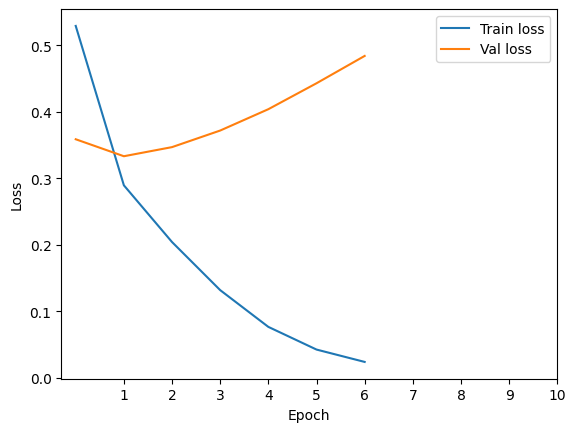

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test accuracy is 0.8632
Test precision is 0.856412876852325
Test recall is 0.8784067085953878
Test f1 is 0.8672703751617077


In [10]:
model_base = Sequential()
model_base.add(Embedding(max_words, 25))
model_base.add(Flatten())
model_base.add(Dense(1, activation='sigmoid'))

test_model(model_base, X_train, y_train, X_test, y_test, X_val, y_val)

Модель показывает неплохое качество, при этом precision и recall довольно сбалансированы и близки друг к другу.

Попробуем далее усложнить модель.

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6481 - loss: 0.6197 - val_accuracy: 0.8504 - val_loss: 0.3541
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8747 - loss: 0.3063 - val_accuracy: 0.8526 - val_loss: 0.3353
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9260 - loss: 0.2086 - val_accuracy: 0.8428 - val_loss: 0.3516
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9681 - loss: 0.1266 - val_accuracy: 0.8403 - val_loss: 0.3790
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9904 - loss: 0.0669 - val_accuracy: 0.8385 - val_loss: 0.4132


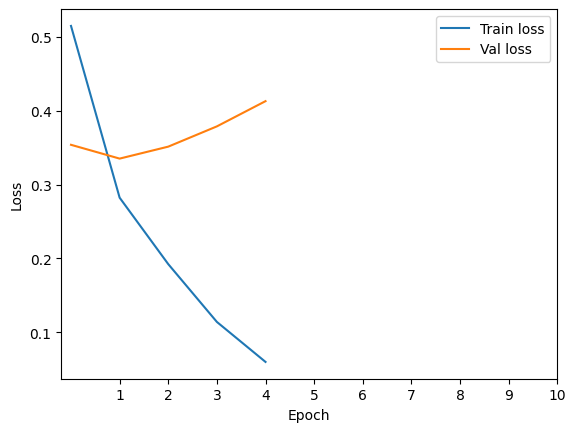

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test accuracy is 0.8512
Test precision is 0.8412537917087968
Test recall is 0.8721174004192872
Test f1 is 0.8564076170869788


In [11]:
model_base2 = Sequential()
model_base2.add(Embedding(max_words, 30))
model_base2.add(Flatten())
model_base2.add(Dense(1, activation='sigmoid'))

test_model(model_base2, X_train, y_train, X_test, y_test, X_val, y_val)

In [12]:
text = 'The best film ever, very good'

In [13]:
seq = tokenizer.texts_to_sequences([text])
pad_seq = pad_sequences(seq, maxlen=100)

In [14]:
model_base.predict(pad_seq)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


array([[0.6056689]], dtype=float32)

In [15]:
y_pred = model_base2.predict(pad_seq)
y_pred = (y_pred > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [16]:
y_pred[0][0]

1

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6435 - loss: 0.6204 - val_accuracy: 0.8538 - val_loss: 0.3480
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8826 - loss: 0.2946 - val_accuracy: 0.8541 - val_loss: 0.3372
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9424 - loss: 0.1801 - val_accuracy: 0.8413 - val_loss: 0.3616
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9845 - loss: 0.0875 - val_accuracy: 0.8369 - val_loss: 0.3956
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9974 - loss: 0.0376 - val_accuracy: 0.8300 - val_loss: 0.4449


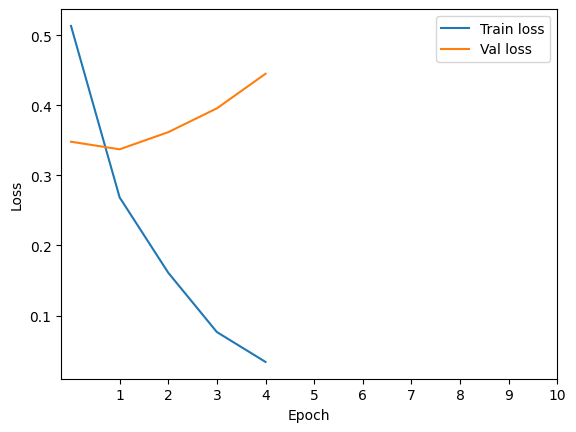

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test accuracy is 0.8549333333333333
Test precision is 0.8461928934010152
Test recall is 0.8736897274633124
Test f1 is 0.8597215059308922


In [17]:
model_base3 = Sequential()
model_base3.add(Embedding(max_words, 45))
model_base3.add(Flatten())
model_base3.add(Dense(1, activation='sigmoid'))

test_model(model_base3, X_train, y_train, X_test, y_test, X_val, y_val)

Модель становится лучше для 2 модели, и хуже для 3

Попробуем рекурентные нейросети, которые часто хорошо подходят для классификации текстов.

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.6090 - loss: 0.6386 - val_accuracy: 0.8093 - val_loss: 0.4351
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8281 - loss: 0.3968 - val_accuracy: 0.8168 - val_loss: 0.4084
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8814 - loss: 0.2922 - val_accuracy: 0.8105 - val_loss: 0.4211
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9219 - loss: 0.2129 - val_accuracy: 0.8096 - val_loss: 0.4691
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9396 - loss: 0.1675 - val_accuracy: 0.7804 - val_loss: 0.6082


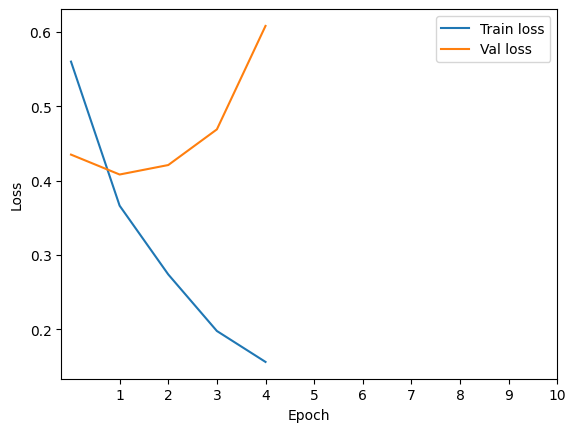

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Test accuracy is 0.8162666666666667
Test precision is 0.8076728924785462
Test recall is 0.8385744234800838
Test f1 is 0.8228336333247621


In [18]:
model_rnn_base = Sequential()
model_rnn_base.add(Embedding(max_words, 15))
model_rnn_base.add(SimpleRNN(12))
model_rnn_base.add(Dense(1, activation='sigmoid'))

test_model(model_rnn_base, X_train, y_train, X_test, y_test, X_val, y_val)

Модель показывает результат хуже

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5813 - loss: 0.6551 - val_accuracy: 0.8178 - val_loss: 0.4307
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.8204 - loss: 0.4144 - val_accuracy: 0.8102 - val_loss: 0.4193
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8673 - loss: 0.3282 - val_accuracy: 0.8115 - val_loss: 0.4511
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8973 - loss: 0.2681 - val_accuracy: 0.8105 - val_loss: 0.4737
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9196 - loss: 0.2171 - val_accuracy: 0.8055 - val_loss: 0.5150


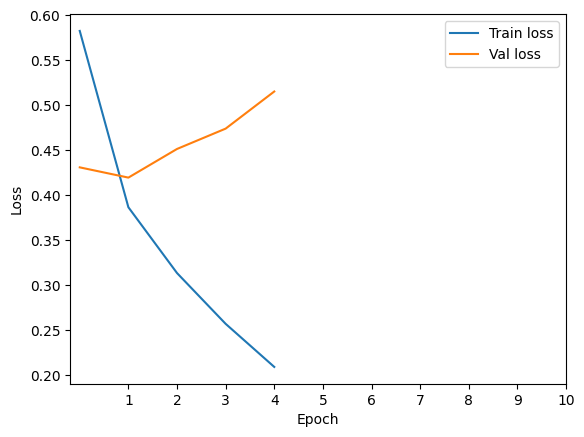

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test accuracy is 0.8098666666666666
Test precision is 0.8249048395867319
Test recall is 0.7950733752620545
Test f1 is 0.8097144382172403


In [19]:
model_rnn2 = Sequential()
model_rnn2.add(Embedding(max_words, 15))
model_rnn2.add(SimpleRNN(12))
model_rnn2.add(Dropout(0.25))
model_rnn2.add(Dense(1, activation='sigmoid'))

test_model(model_rnn2, X_train, y_train, X_test, y_test, X_val, y_val)

Дропаут слой делает только хуже.

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5238 - loss: 0.6926 - val_accuracy: 0.7171 - val_loss: 0.6223
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6627 - loss: 0.6215 - val_accuracy: 0.7287 - val_loss: 0.5462
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7950 - loss: 0.4631 - val_accuracy: 0.7839 - val_loss: 0.4749
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8562 - loss: 0.3579 - val_accuracy: 0.8080 - val_loss: 0.4722
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8988 - loss: 0.2760 - val_accuracy: 0.7832 - val_loss: 0.5359


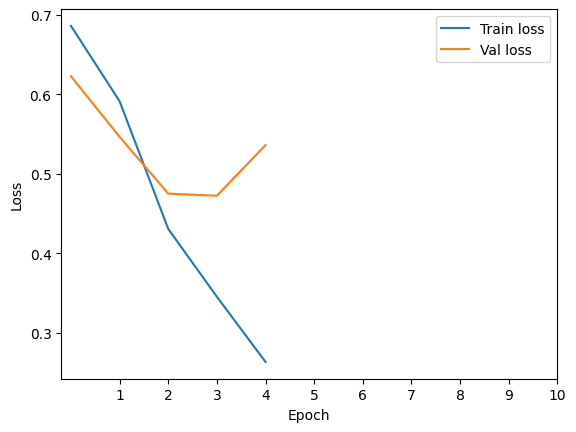

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Test accuracy is 0.7181333333333333
Test precision is 0.7481049562682216
Test recall is 0.6724318658280922
Test f1 is 0.7082528291471155


In [20]:
model_rnn3 = Sequential()
model_rnn3.add(Embedding(max_words, 15))
model_rnn3.add(SimpleRNN(12))
model_rnn3.add(Dropout(0.5))
model_rnn3.add(Dense(1, activation='sigmoid'))

test_model(model_rnn3, X_train, y_train, X_test, y_test, X_val, y_val)

Попробуем модель GRU

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.6035 - loss: 0.6414 - val_accuracy: 0.8297 - val_loss: 0.3971
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.8433 - loss: 0.3822 - val_accuracy: 0.8309 - val_loss: 0.3883
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.8874 - loss: 0.2998 - val_accuracy: 0.8341 - val_loss: 0.3868
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9085 - loss: 0.2648 - val_accuracy: 0.8363 - val_loss: 0.3936
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9155 - loss: 0.2422 - val_accuracy: 0.8309 - val_loss: 0.4009


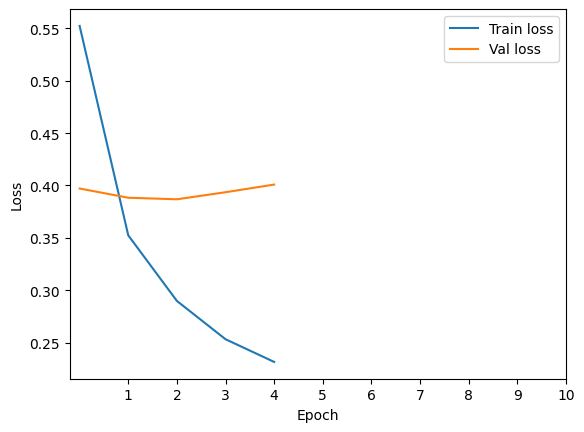

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Test accuracy is 0.8333333333333334
Test precision is 0.8663620788121074
Test recall is 0.7950733752620545
Test f1 is 0.8291883028149768


In [21]:
model_gru_base = Sequential()
model_gru_base.add(Embedding(max_words, 15))
model_gru_base.add(GRU(12))
model_gru_base.add(Dropout(0.5))
model_gru_base.add(Dense(1, activation='sigmoid'))

test_model(model_gru_base, X_train, y_train, X_test, y_test, X_val, y_val)

Модель показывает метрики хуже, чем базовая модель

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6879 - loss: 0.5685 - val_accuracy: 0.8510 - val_loss: 0.3528
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.8719 - loss: 0.3109 - val_accuracy: 0.8444 - val_loss: 0.3502
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.9040 - loss: 0.2531 - val_accuracy: 0.8432 - val_loss: 0.3710
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.9179 - loss: 0.2231 - val_accuracy: 0.8413 - val_loss: 0.3909
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.9291 - loss: 0.1991 - val_accuracy: 0.8369 - val_loss: 0.4132


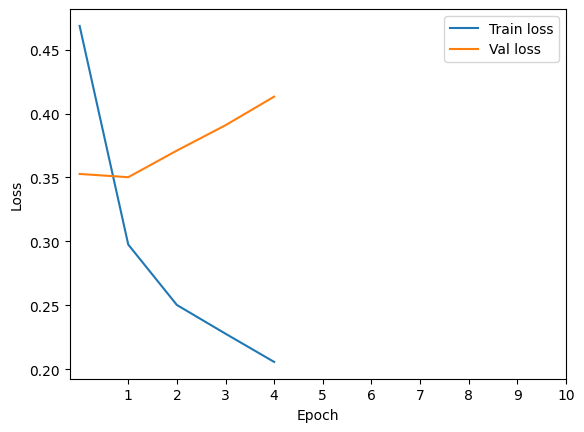

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Test accuracy is 0.8528
Test precision is 0.845565749235474
Test recall is 0.8694968553459119
Test f1 is 0.8573643410852713


In [22]:
model_lstm_base = Sequential()
model_lstm_base.add(Embedding(max_words, 15))
model_lstm_base.add(LSTM(12))
model_lstm_base.add(Dense(1, activation='sigmoid'))

test_model(model_lstm_base, X_train, y_train, X_test, y_test, X_val, y_val)

Модель также хуже, чем базовая, еще и обучается дольше

Ситуация аналогична GRU

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.6741 - loss: 0.5940 - val_accuracy: 0.8353 - val_loss: 0.3771
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.8638 - loss: 0.3336 - val_accuracy: 0.8476 - val_loss: 0.3610
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.9035 - loss: 0.2634 - val_accuracy: 0.8432 - val_loss: 0.3769
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.9227 - loss: 0.2211 - val_accuracy: 0.8432 - val_loss: 0.4036
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9335 - loss: 0.1947 - val_accuracy: 0.8312 - val_loss: 0.4328


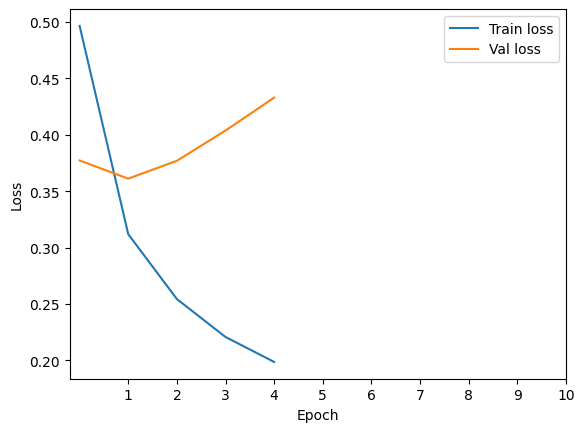

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Test accuracy is 0.8493333333333334
Test precision is 0.8431272355646398
Test recall is 0.8647798742138365
Test f1 is 0.8538163001293662


In [23]:
model_lstm2 = Sequential()
model_lstm2.add(Embedding(max_words, 15))
model_lstm2.add(LSTM(6))
model_lstm2.add(Dense(1, activation='sigmoid'))

test_model(model_lstm2, X_train, y_train, X_test, y_test, X_val, y_val)

Снижение числа нейронов слоя LSTM не дает нужного эффекта, модель хуже чем базовая, однако обучается дольше.

Попробуем несколько слоев LSTM

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 32s 49ms/step - accuracy: 0.6695 - loss: 0.6038 - val_accuracy: 0.8247 - val_loss: 0.4076
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - accuracy: 0.8584 - loss: 0.3653 - val_accuracy: 0.8397 - val_loss: 0.3708
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.9009 - loss: 0.2793 - val_accuracy: 0.8378 - val_loss: 0.3770
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.9188 - loss: 0.2334 - val_accuracy: 0.8381 - val_loss: 0.4170
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - accuracy: 0.9399 - loss: 0.1895 - val_accuracy: 0.8303 - val_loss: 0.4632


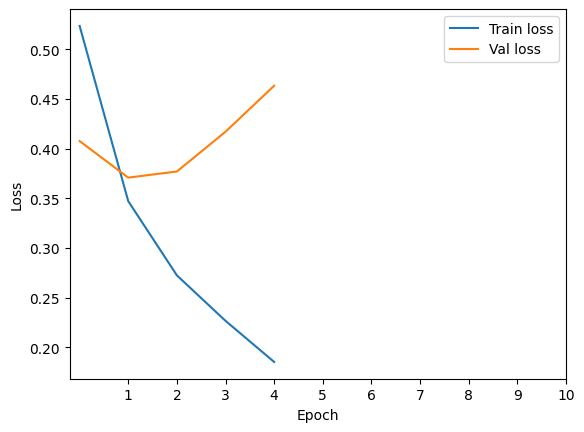

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Test accuracy is 0.8282666666666667
Test precision is 0.8390557939914163
Test recall is 0.8197064989517819
Test f1 is 0.8292682926829268


In [24]:
model_lstm3 = Sequential()
model_lstm3.add(Embedding(max_words, 30))
model_lstm3.add(LSTM(6, return_sequences=True))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(LSTM(6))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(Dense(1, activation='sigmoid'))

test_model(model_lstm3, X_train, y_train, X_test, y_test, X_val, y_val)

Качество выросло незаметно

Попробуем полносвязную нейросеть

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5623 - loss: 0.6695 - val_accuracy: 0.8269 - val_loss: 0.4021
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8225 - loss: 0.4305 - val_accuracy: 0.8394 - val_loss: 0.3665
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8903 - loss: 0.2987 - val_accuracy: 0.8225 - val_loss: 0.4385
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9308 - loss: 0.1951 - val_accuracy: 0.8247 - val_loss: 0.5733
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9564 - loss: 0.1202 - val_accuracy: 0.8250 - val_loss: 0.7064


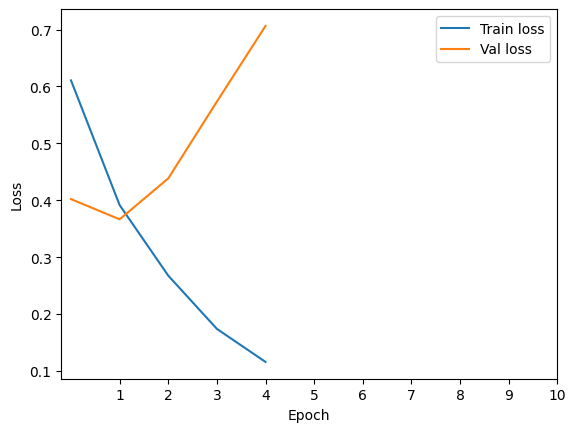

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test accuracy is 0.8301333333333333
Test precision is 0.8125922282341368
Test recall is 0.8658280922431866
Test f1 is 0.8383658969804618


In [25]:
model_fully = Sequential()
model_fully.add(Embedding(max_words, 30))
model_fully.add(Flatten())
model_fully.add(Dense(10, activation='relu'))
model_fully.add(Dropout(0.5))
model_fully.add(Dense(10, activation='relu'))
model_fully.add(Dropout(0.5))
model_fully.add(Dense(1, activation='sigmoid'))

test_model(model_fully, X_train, y_train, X_test, y_test, X_val, y_val)

Переобучение и наивный прогноз

Проверим модель на тесте

In [26]:
df_test = pd.read_csv('../data/test.csv')

In [27]:
texts_test = df_test['text'].astype(str)
labels_test = df_test['positive']

In [28]:
sequences_test = tokenizer.texts_to_sequences(texts_test) #Уже обученный на трейн текстах токенизатор

X_test = pad_sequences(sequences_test, maxlen=maxlen)
y_test = np.array(labels_test)

In [29]:
y_pred = model_base2.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [30]:
calculate_metrics(y_pred, y_test)

Test accuracy is 0.84668
Test precision is 0.8363735154855235
Test recall is 0.862
Test f1 is 0.8489934207934444


Модель показала неплохой результат на тесте, по нашей целевой метрике Accuracy тоже неплохо = 0.855,<br><br/>F1 также довольно хороший = 0.857

В итоге наилучшей моделью оказалась простая модель нейросети, состоящая из слоя эмбеддинга и выходного слоя.


Сохраним эту модель

In [31]:
model_base2.save('../model_params/custom_nn_sentiment.h5')

Сохраним токенизатор


Заметим, что токенизаторы для моделей тональности и рейтинга будут одинаковыми.<br><br/>Значит сохраним токенизатор один раз будем использовать его для двух моделей.

In [ ]:
tokenizer_json = tokenizer.to_json()
with open('../tokenizers_encoder/tokenizer.json', 'w') as f:
    f.write(tokenizer_json)